In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import re
import warnings
warnings.filterwarnings('ignore')


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from catboost import CatBoostRegressor

In [4]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_combined = pd.concat([df_train, df_test], axis=0)
print("Trainset: ", df_train.shape)
print("Testset: ", df_test.shape)
print("Combined: ", df_combined.shape)

Trainset:  (891, 12)
Testset:  (418, 11)
Combined:  (1309, 12)


In [5]:
df_combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
def summarize(DataFrame):
    summary = pd.DataFrame()
    
    # Data Type
    summary['Data Type'] = DataFrame.dtypes
    # The Number of Missing Values
    summary['No of MVs'] = DataFrame.isna().sum()
    # The Percentage of Missing Values
    summary['% of MVs'] = round((DataFrame.isna().sum() / DataFrame.shape[0]) * 100, 2)
    # The Number of Unique Values
    summary['No of Unique'] = DataFrame.apply(lambda x: x.nunique())
    # Max
    summary['Max'] = DataFrame.apply(lambda x: x.max() if pd.api.types.is_numeric_dtype(x) else '-')
    # Min
    summary['Min'] = DataFrame.apply(lambda x: x.min() if pd.api.types.is_numeric_dtype(x) else '-')
    
    # Measures of Central Tendency: Mean, Median, Mode 
    summary['Mean'] = DataFrame.apply(lambda x: round(x.mean(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Median'] = DataFrame.apply(lambda x: x.median() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Mode'] = DataFrame.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else '-')
    
    # Measures of Dispersion: Range, Variance, Standard Deviation
    summary['Range'] = DataFrame.apply(lambda x: x.max() - x.min() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Variance'] = DataFrame.apply(lambda x: x.var() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Standard Deviation'] = DataFrame.apply(lambda x: x.std() if pd.api.types.is_numeric_dtype(x) else '-')
    
    # Measures of Shape: Skew, Kurt
    summary['Skew'] = DataFrame.apply(lambda x: round(x.skew(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Kurt'] = DataFrame.apply(lambda x: round(x.kurt(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    
    return summary


summary = summarize(df_combined)
summary

,Data Type,No of MVs,% of MVs,No of Unique,Max,Min,Mean,Median,Mode,Range,Variance,Standard Deviation,Skew,Kurt
PassengerId,int64,0,0.00,1309,1309,1,655.0,655.0,1,1308,142899.166667,378.020061,0.0,-1.2
Survived,float64,418,31.93,2,1.0,0.0,0.38,0.0,0.0,1.0,0.236772,0.486592,0.48,-1.78
Pclass,int64,0,0.00,3,3,1,2.29,3.0,3,2,0.701969,0.837836,-0.6,-1.32
Name,object,0,0.00,1307,-,-,-,-,"Connolly, Miss. Kate",-,-,-,-,-
Sex,object,0,0.00,2,-,-,-,-,male,-,-,-,-,-
Age,float64,263,20.09,98,80.0,0.17,29.88,28.0,24.0,79.83,207.748787,14.413493,0.41,0.15
SibSp,int64,0,0.00,7,8,0,0.5,0.0,0,8,1.085052,1.041658,3.84,20.04
Parch,int64,0,0.00,8,9,0,0.39,0.0,0,9,0.749195,0.86556,3.67,21.54
Ticket,object,0,0.00,929,-,-,-,-,CA. 2343,-,-,-,-,-
Fare,float64,1,0.08,281,512.3292,0.0,33.3,14.4542,8.05,512.3292,2678.959738,51.758668,4.37,27.03


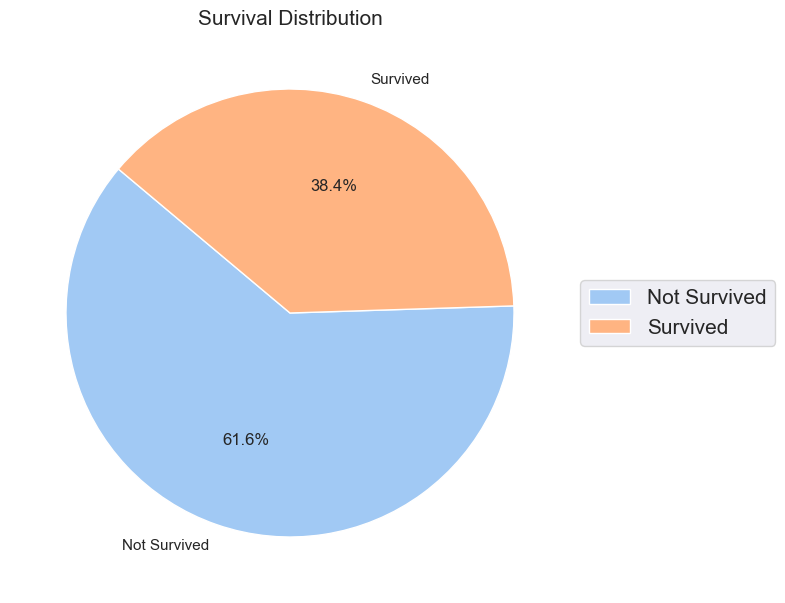

In [80]:
df_viz = df_train.copy()

sns.set(style="darkgrid")

survived_counts = df_viz["Survived"].value_counts()
labels = ["Not Survived", "Survived"]
colors = sns.color_palette("pastel")[0:2]

fig, axs = plt.subplots(figsize=(8, 8))
plt.pie(survived_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Survival Distribution', size=15)
plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5), prop={'size': 15})
plt.subplots_adjust(left=0.1, right=0.8)
plt.show()

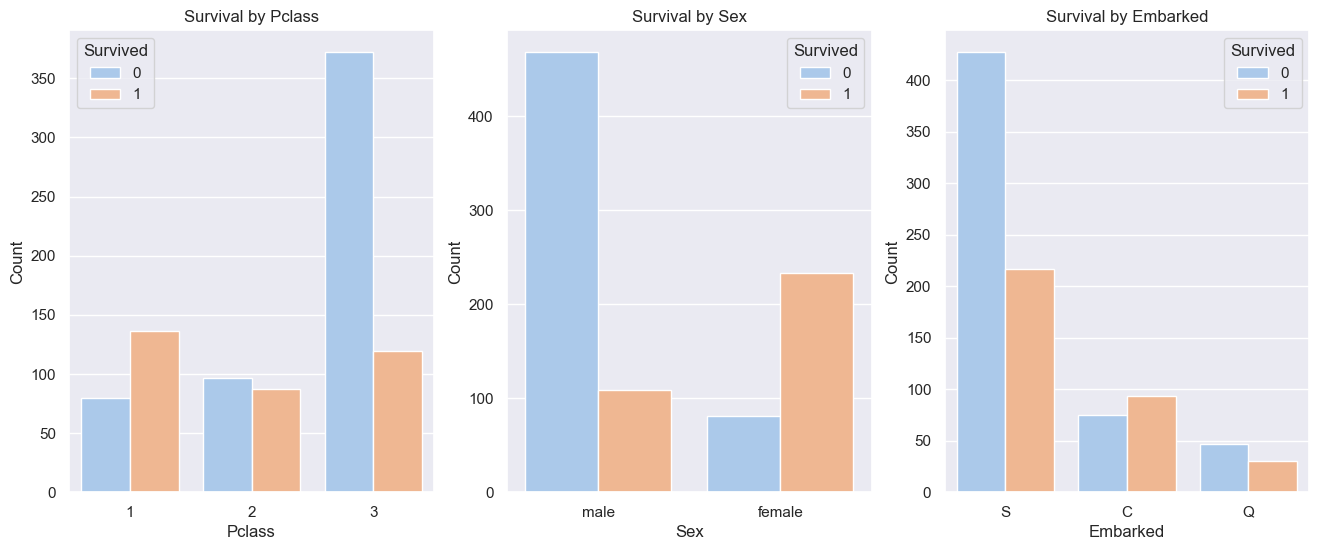

In [8]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(16,6))

sns.countplot(x="Pclass", hue="Survived", data=df_viz, ax=axs[0], palette="pastel")
axs[0].set_title("Survival by Pclass")
axs[0].set_xlabel("Pclass", size=12)
axs[0].set_ylabel("Count", size=12)
axs[0].legend(title="Survived", loc="upper left")

sns.countplot(x="Sex", hue="Survived", data=df_viz, ax=axs[1], palette="pastel")
axs[1].set_title("Survival by Sex")
axs[1].set_xlabel("Sex", size=12)
axs[1].set_ylabel("Count", size=12)
axs[1].legend(title="Survived", loc="upper right")

sns.countplot(x="Embarked", hue="Survived", data=df_viz, ax=axs[2], palette="pastel")
axs[2].set_title("Survival by Embarked")
axs[2].set_xlabel("Embarked", size=12)
axs[2].set_ylabel("Count", size=12)
axs[2].legend(title="Survived", loc="upper right")

plt.tight_layout
plt.show()

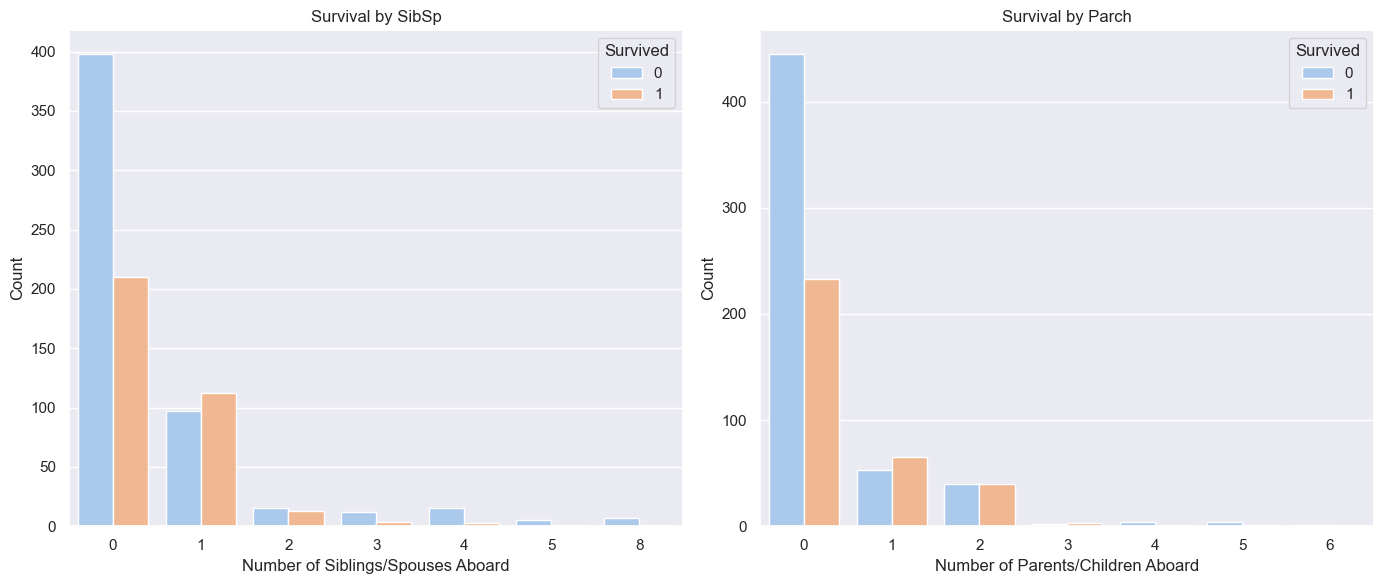

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x="SibSp", hue="Survived", data=df_viz, ax=axs[0], palette="pastel")
axs[0].set_title("Survival by SibSp")
axs[0].set_xlabel("Number of Siblings/Spouses Aboard", size=12)
axs[0].set_ylabel("Count", size=12)

sns.countplot(x="Parch", hue="Survived", data=df_viz, ax=axs[1], palette="pastel")
axs[1].set_title("Survival by Parch")
axs[1].set_xlabel("Number of Parents/Children Aboard", size=12)
axs[1].set_ylabel("Count", size=12)

plt.tight_layout()
plt.show()

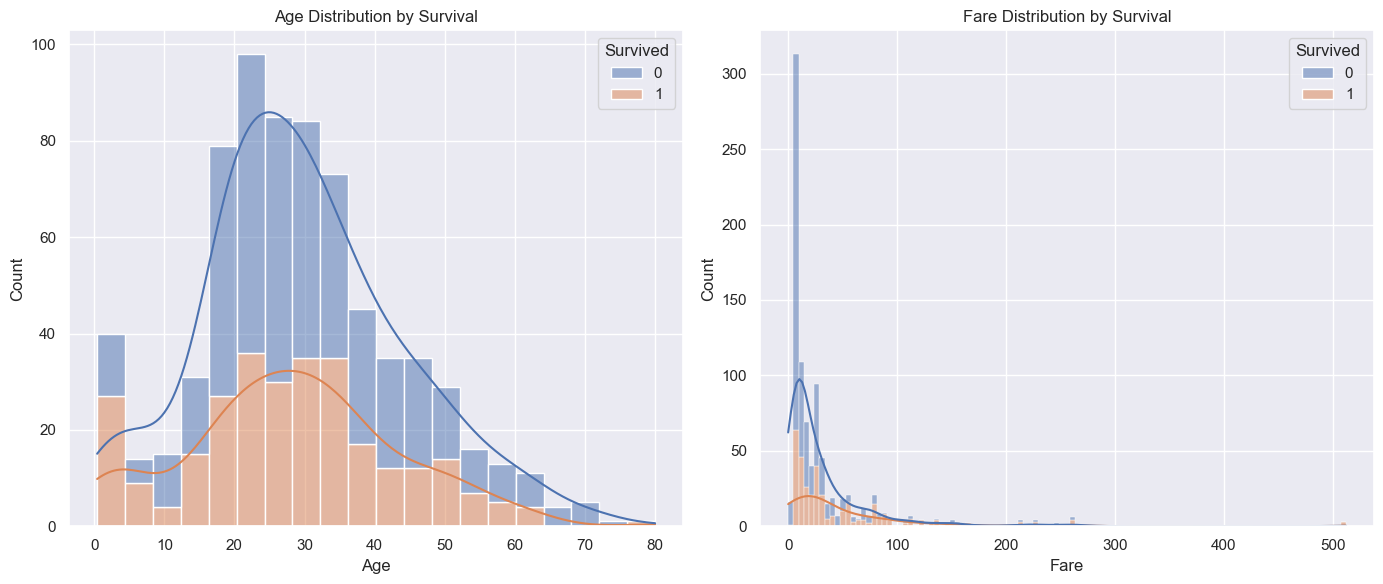

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df_viz, x='Age', hue='Survived', multiple='stack', kde=True, ax=axs[0])
axs[0].set_title('Age Distribution by Survival')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Count')

sns.histplot(df_viz, x='Fare', hue='Survived', multiple='stack', kde=True, ax=axs[1])
axs[1].set_title('Fare Distribution by Survival')
axs[1].set_xlabel('Fare')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


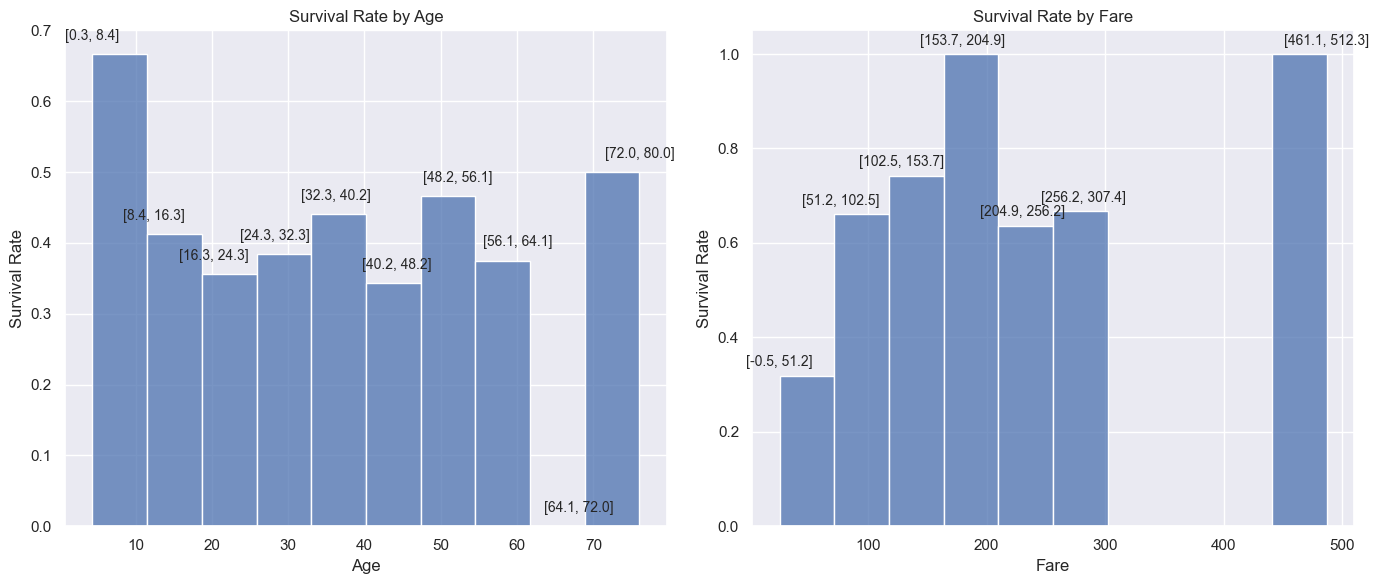

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

age_bins = pd.cut(df_viz['Age'], bins=10)
age_survival_rate = df_viz.groupby(age_bins)['Survived'].mean()
sns.histplot(x=age_survival_rate.index.categories.mid, weights=age_survival_rate.values, bins=10, kde=False, ax=axs[0])
axs[0].set_title('Survival Rate by Age')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Survival Rate')

for i in range(len(age_survival_rate)):
    start_val = age_survival_rate.index.categories[i].left
    end_val = age_survival_rate.index.categories[i].right
    axs[0].text(age_survival_rate.index.categories.mid[i], age_survival_rate.values[i] + 0.02, 
                 f'[{start_val:.1f}, {end_val:.1f}]', ha='center', fontsize=10)

fare_bins = pd.cut(df_viz['Fare'], bins=10)
fare_survival_rate = df_viz.groupby(fare_bins)['Survived'].mean()
sns.histplot(x=fare_survival_rate.index.categories.mid, weights=fare_survival_rate.values, bins=10, kde=False, ax=axs[1])
axs[1].set_title('Survival Rate by Fare')
axs[1].set_xlabel('Fare')
axs[1].set_ylabel('Survival Rate')

for i in range(len(fare_survival_rate)):
    start_val = fare_survival_rate.index.categories[i].left
    end_val = fare_survival_rate.index.categories[i].right
    axs[1].text(fare_survival_rate.index.categories.mid[i], fare_survival_rate.values[i] + 0.02, 
                 f'[{start_val:.1f}, {end_val:.1f}]', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
df1_df2 = df_combined.drop(columns="PassengerId", axis=1)

In [13]:
def extract_title(name):
    match = re.search(r',\s*(\w+)\.', name)
    return match.group(1) if match else None

df1_df2['Titles'] = df1_df2['Name'].apply(extract_title)

In [14]:
print(df1_df2["Titles"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' None 'Jonkheer' 'Dona']


In [15]:
def categorize_title(title):
    if title in ['Mr', 'Mrs', 'Ms', 'Miss']:
        return 'Commoner'
    elif title in ['Master', 'Don', 'Lady', 'Sir', 'Jonkheer', 'Dona']:
        return 'Nobility'
    elif title in ['Rev', 'Dr', 'Major', 'Col', 'Capt']:
        return 'Professional'
    elif title in ['Mme', 'Mlle']:
        return 'Royalty'
    else:
        return np.nan

df1_df2['TitleGroup'] = df1_df2['Titles'].apply(categorize_title)

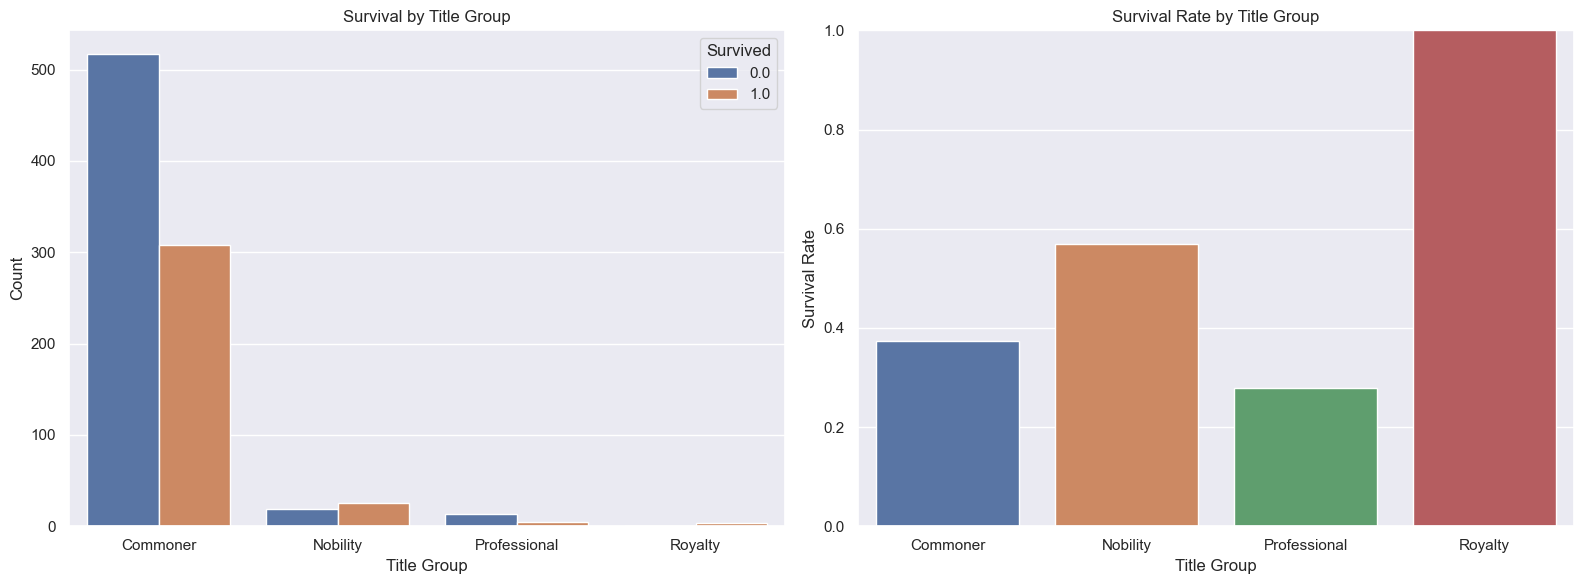

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(x="TitleGroup", hue="Survived", data=df1_df2[df1_df2["Survived"].notnull()], ax=axs[0], palette="deep")
axs[0].set_title("Survival by Title Group")
axs[0].set_xlabel("Title Group")
axs[0].set_ylabel("Count")

survival_rates = df1_df2.groupby('TitleGroup')['Survived'].mean()
sns.barplot(x=survival_rates.index, y=survival_rates.values, ax=axs[1], palette="deep")
axs[1].set_title('Survival Rate by Title Group')
axs[1].set_xlabel('Title Group')
axs[1].set_ylabel('Survival Rate')
axs[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [17]:
df1_df2["TitleGroup"] = df1_df2["TitleGroup"].map({"Professional": 0, "Commoner": 1, "Nobility": 2, "Royalty": 3})

In [18]:
def extract_last_name(name):
    match = re.search(r'^(\w+),', name)
    return match.group(1) if match else None

df1_df2['LastName'] = df1_df2['Name'].apply(extract_last_name)

In [19]:
lastname_group_size = df1_df2.groupby(by="LastName")["LastName"].transform("size")
df1_df2["LastNameGroupSize"] = lastname_group_size

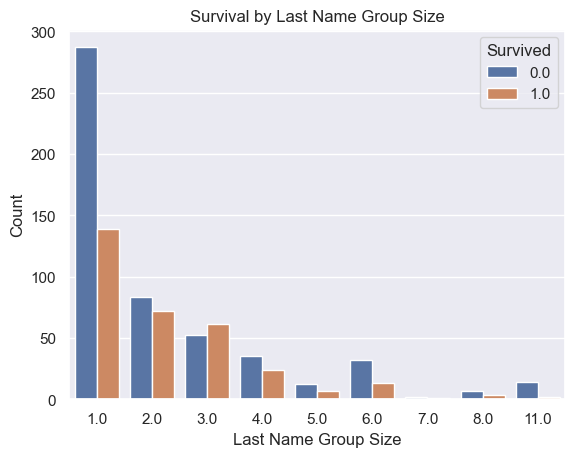

In [20]:
sns.countplot(x="LastNameGroupSize", hue="Survived", data=df1_df2[df1_df2["Survived"].notnull()], palette="deep")
plt.title("Survival by Last Name Group Size")
plt.xlabel("Last Name Group Size")
plt.ylabel("Count")
plt.show()

In [21]:
df_df0 = df1_df2.copy()
df_df0.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,TitleGroup,LastName,LastNameGroupSize
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1.0,Braund,2.0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1.0,Cumings,2.0
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1.0,Heikkinen,1.0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1.0,Futrelle,2.0
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1.0,Allen,2.0


In [22]:
df_df0['Sex'] = df_df0['Sex'].map({'male': 1, 'female': 0})

In [23]:
df_v2 = df_df0.copy()
df_v2.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,TitleGroup,LastName,LastNameGroupSize
0,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1.0,Braund,2.0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1.0,Cumings,2.0
2,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1.0,Heikkinen,1.0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs,1.0,Futrelle,2.0
4,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,1.0,Allen,2.0


In [24]:
df_v2['FamilySize'] = df_v2['SibSp'] + df_v2['Parch'] + 1
df_v2['Solo'] = df_v2['FamilySize'].apply(lambda x: 1 if x > 1 else 0)

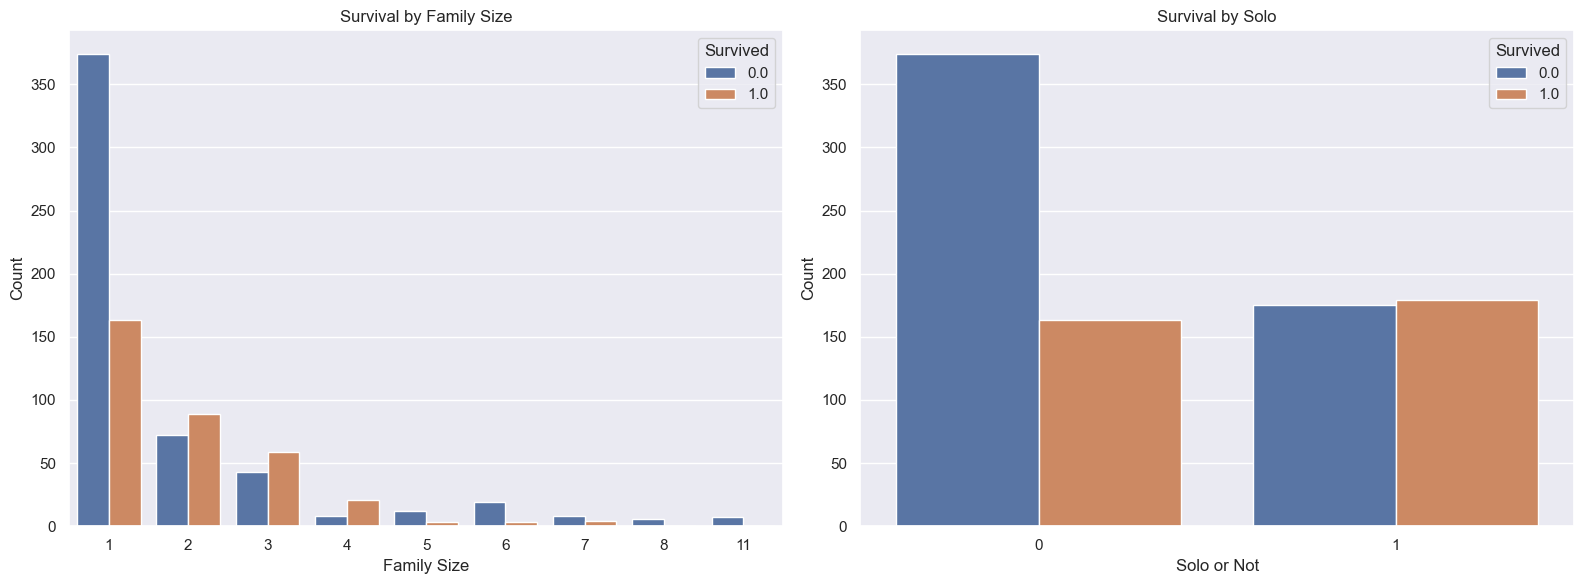

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(x="FamilySize", hue="Survived", data=df_v2[df_v2["Survived"].notnull()], ax=axs[0], palette="deep")
axs[0].set_title("Survival by Family Size")
axs[0].set_xlabel("Family Size")
axs[0].set_ylabel("Count")

sns.countplot(x="Solo", hue="Survived", data=df_v2[df_v2["Survived"].notnull()], ax=axs[1], palette="deep")
axs[1].set_title("Survival by Solo")
axs[1].set_xlabel("Solo or Not")
axs[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [26]:
def categorize_family_size(familysize):
    if familysize == 1:
        return 0
    elif familysize <= 4:
        return 1
    elif familysize > 4:
        return 2
    else:
        return np.nan

df_v2["FamilySizeGroup"] = df_v2["FamilySize"].apply(categorize_family_size)

In [27]:
df_df3 = df_v2.copy()
df_df3.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,TitleGroup,LastName,LastNameGroupSize,FamilySize,Solo,FamilySizeGroup
0,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1.0,Braund,2.0,2,1,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1.0,Cumings,2.0,2,1,1
2,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1.0,Heikkinen,1.0,1,0,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs,1.0,Futrelle,2.0,2,1,1
4,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,1.0,Allen,2.0,1,0,0


In [28]:
df_df4 = df_df3.drop(columns="Ticket", axis=1)

In [29]:
df_df5 = df_df4.copy()
df_df5.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Titles,TitleGroup,LastName,LastNameGroupSize,FamilySize,Solo,FamilySizeGroup
0,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,NaN,S,Mr,1.0,Braund,2.0,2,1,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C85,C,Mrs,1.0,Cumings,2.0,2,1,1
2,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,NaN,S,Miss,1.0,Heikkinen,1.0,1,0,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C123,S,Mrs,1.0,Futrelle,2.0,2,1,1
4,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,NaN,S,Mr,1.0,Allen,2.0,1,0,0


In [30]:
df_df5["CabinCapital"] = df_df5["Cabin"].apply(lambda x: x.strip()[0] if pd.notna(x) else x)

In [31]:
df_df6 = df_df5.copy()
df_df6.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Titles,TitleGroup,LastName,LastNameGroupSize,FamilySize,Solo,FamilySizeGroup,CabinCapital
0,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,NaN,S,Mr,1.0,Braund,2.0,2,1,1,NaN
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C85,C,Mrs,1.0,Cumings,2.0,2,1,1,C
2,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,NaN,S,Miss,1.0,Heikkinen,1.0,1,0,0,NaN
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C123,S,Mrs,1.0,Futrelle,2.0,2,1,1,C
4,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,NaN,S,Mr,1.0,Allen,2.0,1,0,0,NaN


In [32]:
df_combined.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [33]:
df_df7 = df_df6.drop(columns=["Name", "Titles", "LastName", "Cabin"], axis=1)
df_df7.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,TitleGroup,LastNameGroupSize,FamilySize,Solo,FamilySizeGroup,CabinCapital
0,0.0,3,1,22.0,1,0,7.2500,S,1.0,2.0,2,1,1,NaN
1,1.0,1,0,38.0,1,0,71.2833,C,1.0,2.0,2,1,1,C
2,1.0,3,0,26.0,0,0,7.9250,S,1.0,1.0,1,0,0,NaN
3,1.0,1,0,35.0,1,0,53.1000,S,1.0,2.0,2,1,1,C
4,0.0,3,1,35.0,0,0,8.0500,S,1.0,2.0,1,0,0,NaN


In [34]:
df_df7["CabinCapital"].fillna("Others", inplace=True)

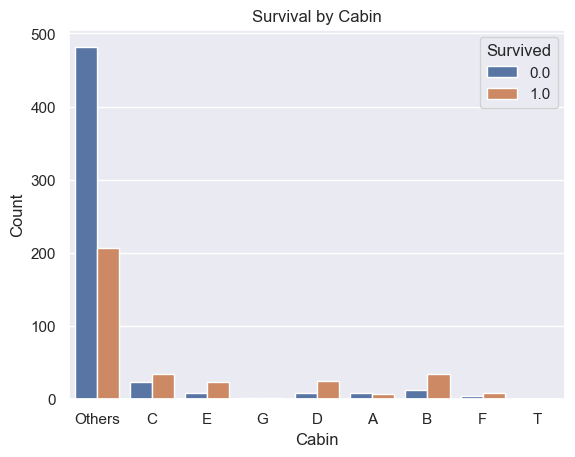

In [35]:
sns.countplot(x="CabinCapital", hue="Survived", data=df_df7[df_df7["Survived"].notnull()], palette="deep")
plt.title("Survival by Cabin")
plt.xlabel("Cabin")
plt.ylabel("Count")
plt.show()

In [36]:
print(df_df7["CabinCapital"].unique())

['Others' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


In [37]:
df_df7["CabinCapital"] = df_df7["CabinCapital"].map({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8, "Others": 0})

In [38]:
df_df8 = df_df7.copy()
df_df8.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,TitleGroup,LastNameGroupSize,FamilySize,Solo,FamilySizeGroup,CabinCapital
0,0.0,3,1,22.0,1,0,7.2500,S,1.0,2.0,2,1,1,0
1,1.0,1,0,38.0,1,0,71.2833,C,1.0,2.0,2,1,1,3
2,1.0,3,0,26.0,0,0,7.9250,S,1.0,1.0,1,0,0,0
3,1.0,1,0,35.0,1,0,53.1000,S,1.0,2.0,2,1,1,3
4,0.0,3,1,35.0,0,0,8.0500,S,1.0,2.0,1,0,0,0


In [41]:
df_X = df_df8.drop("Survived", axis=1)
df_y = df_df8["Survived"]

In [46]:
from sklearn.impute import IterativeImputer
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')


# Initialize the regressor
catboost_regressor = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_state=0
)

# Encode categorical columns or handle them separately
df_X_encoded = pd.get_dummies(df_X, drop_first=True)

# Impute missing values
imputer = IterativeImputer(estimator=catboost_regressor, random_state=0)
data_imputed = imputer.fit_transform(df_X_encoded)
data_imputed = pd.DataFrame(data_imputed, columns=df_X_encoded.columns)



In [49]:
data_imputed = data_imputed.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)

df_df9 = pd.concat([data_imputed, df_y], axis=1)

In [52]:
df_df9.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,TitleGroup,LastNameGroupSize,FamilySize,Solo,FamilySizeGroup,CabinCapital,Embarked_Q,Embarked_S,Survived
0,3.0,1.0,22.0,1.0,0.0,7.2500,1.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,38.0,1.0,0.0,71.2833,1.0,2.0,2.0,1.0,1.0,3.0,0.0,0.0,1.0
2,3.0,0.0,26.0,0.0,0.0,7.9250,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,35.0,1.0,0.0,53.1000,1.0,2.0,2.0,1.0,1.0,3.0,0.0,1.0,1.0
4,3.0,1.0,35.0,0.0,0.0,8.0500,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<!-- # 🧹**05. Data Preprocessing - Part.02**🧹 -->

<!-- 01) Round Up - Age, Embarked, and LastNameGroupSize -->

In [58]:
df_df9["Pclass"] = df_df9["Pclass"].round().astype(int)
df_df9["Sex"] = df_df9["Sex"].round().astype(int)
df_df9["Age"] = df_df9["Age"].round().astype(int)
df_df9["SibSp"] = df_df9["SibSp"].round().astype(int)
df_df9["Parch"] = df_df9["Parch"].round().astype(int)
df_df9["Embarked_Q"] = df_df9["Embarked_Q"].round().astype(int)
df_df9["TitleGroup"] = df_df9["TitleGroup"].round().astype(int)
df_df9["LastNameGroupSize"] = df_df9["LastNameGroupSize"].round().astype(int)
df_df9["FamilySize"] = df_df9["FamilySize"].round().astype(int)
df_df9["FamilySizeGroup"] = df_df9["FamilySizeGroup"].round().astype(int)
df_df9["Solo"] = df_df9["Solo"].round().astype(int)
df_df9["CabinCapital"] = df_df9["CabinCapital"].round().astype(int)

<!-- 02) Categorize - Fare & Age -->

In [59]:
def categorize_fare(fare):
    if fare <= 50:
        return 0
    elif fare <= 150:
        return 1
    elif fare <= 200:
        return 2
    elif fare <= 300:
        return 3
    else:
        return 4

df_df9["FareGroup"] = df_df9["Fare"].apply(categorize_fare)

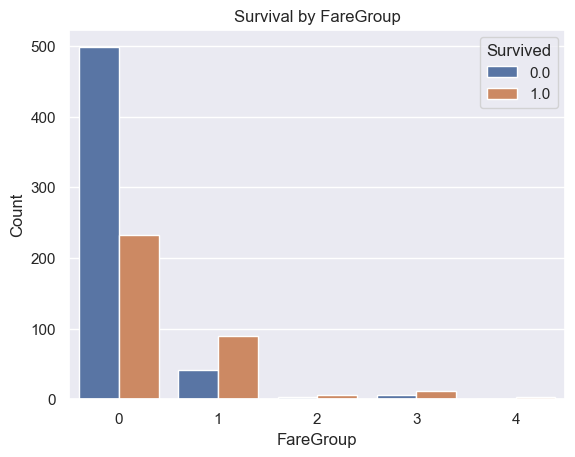

In [61]:
sns.countplot(x="FareGroup", hue="Survived", data=df_df9[df_df9["Survived"].notnull()], palette="deep")
plt.title("Survival by FareGroup")
plt.xlabel("FareGroup")
plt.ylabel("Count")
plt.show()

In [62]:
def categorize_age(age):
    if age <= 8:
        return 0
    elif age <= 16:
        return 1
    elif age <= 24:
        return 2
    elif age <= 32:
        return 3
    elif age <= 40:
        return 4
    elif age <= 48:
        return 5
    elif age <= 56:
        return 6
    elif age <= 64:
        return 7
    else:
        return 8

df_df9["AgeGroup"] = df_df9["Age"].apply(categorize_age)

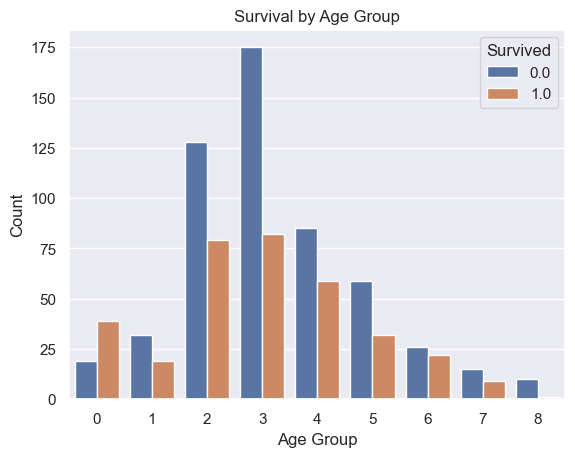

In [64]:
sns.countplot(x="AgeGroup", hue="Survived", data=df_df9[df_df9["Survived"].notnull()], palette="deep")
plt.title("Survival by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

In [65]:
data_cleaned = df_df9.copy()
data_cleaned.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,TitleGroup,LastNameGroupSize,FamilySize,Solo,FamilySizeGroup,CabinCapital,Embarked_Q,Embarked_S,Survived,FareGroup,AgeGroup
0,3,1,22,1,0,7.2500,1,2,2,1,1,0,0,1,0.0,0,2
1,1,0,38,1,0,71.2833,1,2,2,1,1,3,0,0,1.0,1,4
2,3,0,26,0,0,7.9250,1,1,1,0,0,0,0,1,1.0,0,3
3,1,0,35,1,0,53.1000,1,2,2,1,1,3,0,1,1.0,1,4
4,3,1,35,0,0,8.0500,1,2,1,0,0,0,0,1,0.0,0,4


<!-- 🚀06. Modeling🚀 -->


<!-- 01) CatBoost -->

In [66]:
data1_selected = data_cleaned.drop(columns=["LastNameGroupSize", "SibSp", "Parch", "Fare", "Age", "FamilySizeGroup"], axis=1)
data1_selected.head()

,Pclass,Sex,TitleGroup,FamilySize,Solo,CabinCapital,Embarked_Q,Embarked_S,Survived,FareGroup,AgeGroup
0,3,1,1,2,1,0,0,1,0.0,0,2
1,1,0,1,2,1,3,0,0,1.0,1,4
2,3,0,1,1,0,0,0,1,1.0,0,3
3,1,0,1,2,1,3,0,1,1.0,1,4
4,3,1,1,1,0,0,0,1,0.0,0,4


In [68]:
from sklearn.model_selection import train_test_split

df_model = data1_selected[data1_selected["Survived"].notnull()]
df_predict = data1_selected[data1_selected["Survived"].isnull()]

X = df_model.drop(columns=["Survived"], axis=1)
y = df_model["Survived"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
from catboost import CatBoostClassifier

catboost_clf = CatBoostClassifier(random_state=42, verbose=0)

In [72]:
param_grid = {
    'bagging_temperature': [0.1, 0.5, 1.0],
    'border_count': [32, 64],
    'depth': [4, 6],
    'iterations': [50, 100, 200],
    'l2_leaf_reg': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'random_strength': [0.1, 0.2, 0.5],
    'subsample': [1.0]
}

In [74]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=catboost_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'bagging_temperature': 0.1, 'border_count': 32, 'depth': 4, 'iterations': 50, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'random_strength': 0.1, 'subsample': 1.0}
Best Score: 0.8342263370432385


In [75]:
from sklearn.metrics import make_scorer, accuracy_score, matthews_corrcoef, roc_auc_score, balanced_accuracy_score

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8268156424581006


In [76]:
catboost_clf = CatBoostClassifier(bagging_temperature=0.1, border_count=32, depth=4, iterations=50, l2_leaf_reg=3, learning_rate=0.01, random_strength=0.1, subsample=1, random_state=42, verbose=0)
catboost_clf.fit(X, y)

In [78]:
X_predict = df_predict.drop(columns=["Survived"], axis=1)
prediction_cat = catboost_clf.predict(X_predict)

submission_cat = pd.read_csv("gender_submission.csv")
submission_cat["Survived"] = prediction_cat.astype(int)

submission_cat.to_csv("Titanic_Result.csv", index=False) 

<!-- This endeavor taught me an invaluable lesson.

It's true that "Garbage In, Garbage Out". -->
<!-- I've tried everything, including GridSearch, AutoML, and Optuna. But in the end, data preparation was the game-changer. -->